In [3]:
!pip install tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     --------------------- ------------------ 30.7

   -------------- ----------------------- 116.3/300.9 MB 539.7 kB/s eta 0:05:43
   -------------- ----------------------- 116.3/300.9 MB 538.4 kB/s eta 0:05:43
   -------------- ----------------------- 116.3/300.9 MB 538.0 kB/s eta 0:05:44
   -------------- ----------------------- 116.3/300.9 MB 538.4 kB/s eta 0:05:43
   -------------- ----------------------- 116.3/300.9 MB 537.5 kB/s eta 0:05:44
   -------------- ----------------------- 116.3/300.9 MB 537.1 kB/s eta 0:05:44
   -------------- ----------------------- 116.4/300.9 MB 536.6 kB/s eta 0:05:44
   -------------- ----------------------- 116.4/300.9 MB 536.2 kB/s eta 0:05:45
   -------------- ----------------------- 116.4/300.9 MB 535.8 kB/s eta 0:05:45
   -------------- ----------------------- 116.4/300.9 MB 535.3 kB/s eta 0:05:45
   -------------- ----------------------- 116.4/300.9 MB 534.9 kB/s eta 0:05:45
   -------------- ----------------------- 116.4/300.9 MB 534.0 kB/s eta 0:05:46
   -------------- ----------------------

Found 10042 images belonging to 2 classes.
Found 2154 images belonging to 2 classes.
Found 2152 images belonging to 2 classes.
Epoch 1/20


1256/1256 [==============================] - ETA: 0s - loss: 0.1321 - accuracy: 0.9509
Epoch 1: val_loss improved from inf to 0.07634, saving model to VGG16_model.keras
1256/1256 [==============================] - 759s 603ms/step - loss: 0.1321 - accuracy: 0.9509 - val_loss: 0.0763 - val_accuracy: 0.9689
Epoch 2/20
1256/1256 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.9806
Epoch 2: val_loss improved from 0.07634 to 0.06389, saving model to VGG16_model.keras
1256/1256 [==============================] - 696s 554ms/step - loss: 0.0573 - accuracy: 0.9806 - val_loss: 0.0639 - val_accuracy: 0.9735
Epoch 3/20
1256/1256 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9823
Epoch 3: val_loss improved from 0.06389 to 0.02103, saving model to VGG16_model.keras
1256/1256 [==============================] - 691s

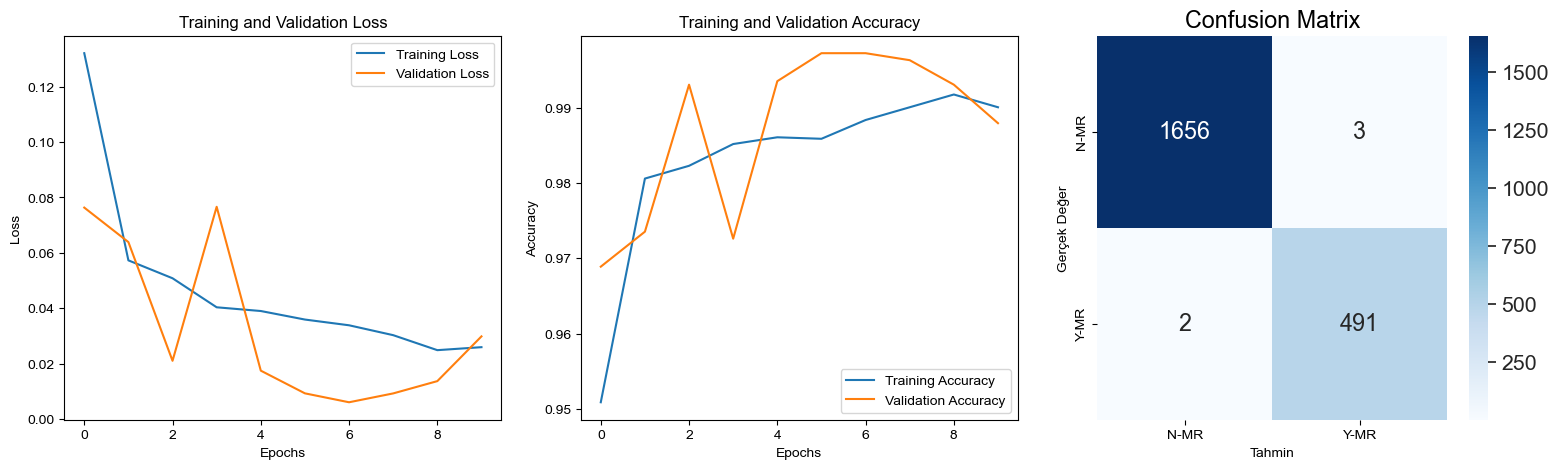


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1659
           1       0.99      1.00      0.99       493

    accuracy                           1.00      2152
   macro avg       1.00      1.00      1.00      2152
weighted avg       1.00      1.00      1.00      2152



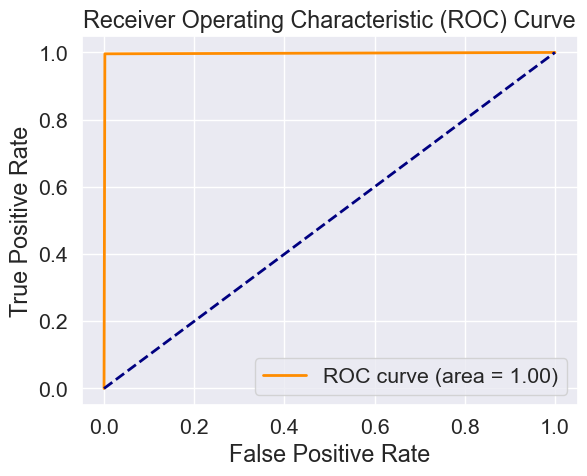

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Early stopping callback'i oluşturma
early_stopping = EarlyStopping(
    monitor='val_loss',  # Takip edilecek metrik (örneğin, doğrulama kaybı)
    patience=3,  # Metrik iyileşmediğinde veya durduğunda beklenen epoch sayısı
    restore_best_weights=True  # En iyi ağırlıkları geri yükleme
)

# Define image dataset
# why do we rescale?
WIDTH, HEIGHT = 128, 128
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0, shear_range=0.25, horizontal_flip=True, rotation_range=20)

train_dataset = image_generator.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\train",
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

image_generator_submission = ImageDataGenerator(rescale=1/255, validation_split=0.5)
validation = image_generator_submission.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

test_dataset = image_generator_submission.flow_from_directory(
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="validation",
    class_mode=None
)

# VGG16 modelini yükleme
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))

# Yeni model oluşturma
model = Sequential([
    vgg16_model,  # VGG16 modelini ekliyoruz
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64,activation='relu'),
    Dropout(0.4),
    Dense(train_dataset.num_classes, activation='softmax')
])

# Katmanları dondurma
for layer in vgg16_model.layers:
    layer.trainable = False

# Modeli derleme
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg16_checkpoint = ModelCheckpoint('VGG16_model.keras', verbose=1, save_best_only=True)


# Model eğitimi
history = model.fit(train_dataset, epochs=20, validation_data=validation, callbacks=[vgg16_checkpoint,early_stopping])

# Eğitim ve doğrulama kaybı ve doğruluğu görselleştirme
plt.figure(figsize=(16, 5))

# Eğitim ve doğrulama kaybı
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Confusion Matrix
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true = test_dataset.labels
conf_matrix = confusion_matrix(y_true, y_pred)

# Karışıklık matrisini görselleştirme
plt.subplot(1, 3, 3)
sns.set(font_scale=1.4)  # Font ölçeğini ayarla
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['N-MR', 'Y-MR'],
            yticklabels=['N-MR', 'Y-MR'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek Değer')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(class_report)

# ROC Eğrisi ve AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define image dataset
WIDTH, HEIGHT = 128, 128
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0, shear_range=0.25, horizontal_flip=True, rotation_range=20)

train_dataset = image_generator.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\train",
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

image_generator_submission = ImageDataGenerator(rescale=1/255, validation_split=0.5)
validation = image_generator_submission.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

test_dataset = image_generator_submission.flow_from_directory(
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="validation",
    class_mode=None
)



Found 10042 images belonging to 2 classes.
Found 2154 images belonging to 2 classes.
Found 2152 images belonging to 2 classes.


68/68 [==============================] - 157s 2s/step


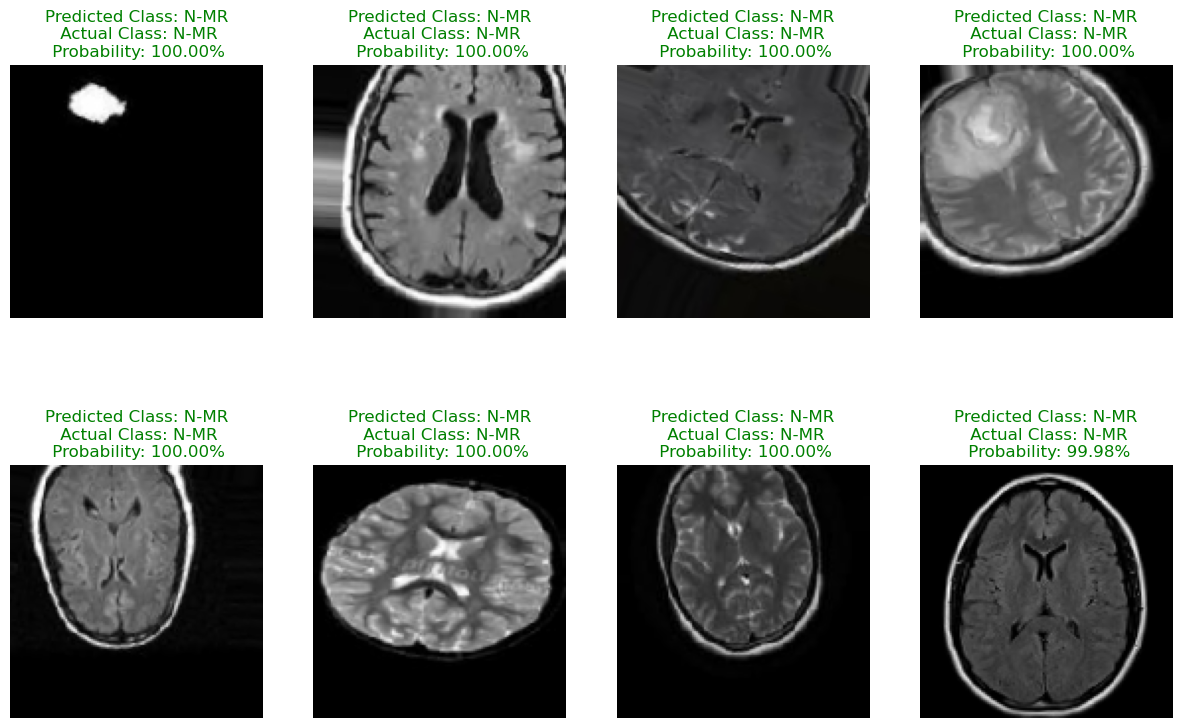

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model


vgg16_model=load_model("VGG16_model.keras")




vgg16_predictions=vgg16_model.predict(test_dataset)




vgg16_true_classes=test_dataset.classes


categories={0:'N-MR', 1:'Y-MR'}
vgg16_predicted_classes = np.argmax(vgg16_predictions, axis=1)

predicted_classes = np.argmax(vgg16_predictions, axis=1)  # En yüksek olasılığa sahip sınıfları al
prediction_probabilities = np.max(vgg16_predictions, axis=1)  # En yüksek olasılıkları al
batch_1_img = train_dataset[0]
plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(5,4,i+1)
    plt.imshow(batch_1_img[0][i])
    predicted_class_label=categories[vgg16_predicted_classes[i]]
    actual_class_label=categories[vgg16_true_classes[i]]

    if vgg16_predicted_classes[i] == vgg16_true_classes[i]:
        title_color='green'
    else:
        title_color='red'

    prediction_probability = prediction_probabilities[i] * 100

    title = f'Predicted Class: {predicted_class_label}\n Actual Class: {actual_class_label}\n Probability: {prediction_probability:.2f}%'
    plt.title(title,color=title_color)
    plt.axis('off')
plt.subplots_adjust(top=1.4)
plt.show()
